# Reference
https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/

# Network configuration

Even though research paper is named Deep Face, researchers give VGG-Face name to the model. This might be because Facebook researchers also called their face recognition system DeepFace – without blank. VGG-Face is deeper than Facebook’s Deep Face, it has 22 layers and 37 deep units.

The structure of the VGG-Face model is demonstrated below. Only output layer is different than the imagenet version – you might compare.

![image](https://i0.wp.com/sefiks.com/wp-content/uploads/2018/08/vgg-face-model.png?ssl=1)
VGG-Face model
![image](https://i0.wp.com/sefiks.com/wp-content/uploads/2019/04/vgg-face-architecture.jpg?w=1805&ssl=1)
Visualization of VGG-Face


# Extract VGG-Face Features

In [5]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Activation, Flatten
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
import numpy as np
import pickle
import os
from tqdm import tqdm

In [10]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [215]:
def extract_feature(input, output = None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    
    model.load_weights('./weights/vgg_face_weights.h5')
    
    vgg_face_descriptor = Model(
    inputs=model.layers[0].input,
    outputs=model.layers[-2].output)
    
    print('converting images from %s'%(input))
    face_array_representation = {}
    if os.path.isdir(input):
        for img_name in tqdm(os.listdir(input)):
            face_array_representation[img_name] = vgg_face_descriptor.predict(preprocess_image('{}/{}'.format(input,img_name)))[0,:]
    if os.path.isfile(input):
        img_name = input.split('/')[-1]
        face_array_representation[img_name] = vgg_face_descriptor.predict(preprocess_image('{}'.format(input)))[0,:]
    if output == None:
        return face_array_representation
    # save array to pickle
    print('output array to {}'.format(output))
    with open(output,'wb') as f:
        pickle.dump(face_array_representation, f)

In [38]:
extract_feature(input = './face', output = './face_array_representation.pkl')

100%|██████████| 883/883 [18:21<00:00,  1.25s/it]


In [216]:
extract_feature(input='./test/0', output='./face_array_test.pkl')

converting images from ./test/0


100%|██████████| 9/9 [00:12<00:00,  1.31s/it]


output array to ./face_array_test.pkl


# Train Regression Model using extracted features

In [240]:
import pandas as pd
import pickle

In [241]:
with open('./face_array_representation.pkl','rb') as f:
    loaded_face_array = pickle.load(f)

In [242]:
df_face_feature = pd.DataFrame(loaded_face_array).T
df_face_feature.head()

,0,1,2,3,4,5,6,7,8,9,...,2612,2613,2614,2615,2616,2617,2618,2619,2620,2621
248038.jpg,1.571467,-0.671615,-1.159301,1.293227,-0.093556,-0.697550,0.148561,0.685544,0.704531,-0.749262,...,-1.834303,-0.444321,-2.283065,0.731417,-0.269255,-0.156841,-1.303293,-1.313362,1.072968,0.399883
250464.jpg,4.145911,-0.537042,0.426129,-0.076368,-1.404314,5.505557,1.766905,-0.137578,-0.028811,1.579135,...,-0.207776,-0.165933,0.203628,3.507101,0.909248,-1.001198,-4.078630,-2.369386,2.183077,1.695219
263711.jpg,3.517062,-1.236114,0.551771,1.814112,0.669282,1.231691,-0.022512,1.994583,0.180609,-0.126408,...,-1.078979,-0.967290,-2.290201,2.092639,-0.915509,-2.594831,-2.218287,-0.608502,-1.127747,1.167402
270020.jpg,1.655680,1.908274,1.573434,0.921428,0.585250,4.087645,3.144320,1.453200,2.634692,1.265123,...,-0.545173,0.093986,-1.480046,2.034657,1.998626,-0.455827,-1.490269,-4.067970,2.701385,4.466756
277774.jpg,2.165415,0.742228,-0.558265,2.981857,0.493239,2.308912,1.586248,3.301033,1.498757,2.043516,...,-1.973742,-0.532828,-1.948492,0.832768,1.065996,-2.232458,-3.791786,-0.385528,1.631693,2.910033


In [243]:
df = pd.read_csv('./full_coded.csv')
df.head()

,age,book_date,bookid,city,eyes,hair,height,holding_location,name,nameid,race,sex,weight,bmi,label
0,54,3/10/2017 10:05:55 AM,248038,"WAUKEE, IA",Brown,Black,71.0,PCJ,JAMES DEYO ROBINSON,7482,Black,Male,280,39.047808,1
1,26,4/23/2017 8:57:43 AM,250464,"DES MOINES, IA",Brown,Black,71.0,Cherokee Mental Health,CORDERRO ALTON LAURENCE,754952,Black,Male,210,29.285856,0
2,24,12/7/2017 4:00:07 PM,263711,"DES MOINES, IA",Green,Blonde,69.0,PCJ,TAYLOR LOUIS HARLAN,644421,White,Male,290,42.820836,1
3,21,4/1/2018 3:24:44 AM,270020,"DES MOINES, IA",Brown,Black,63.0,PCJ,MALIK TYRONE MANDUJANO,699804,Black,Male,130,23.025951,0
4,29,8/5/2018 9:26:54 PM,277774,"DES MOINES, IA",Blue,Blonde,74.0,PCJ,DUSTIN GLEN BLACK,238047,White,Male,230,29.527027,0


In [244]:
IN_TRAIN_RATIO = 0.8
df['img_name'] = df.bookid.map(lambda i: str(i)+'.jpg')
df = df[['age','sex','race','height','weight','bmi', 'img_name']]
in_train = np.random.uniform(size = len(df)) <= IN_TRAIN_RATIO
df_train = df.loc[in_train,:]
df_valid = df.loc[~in_train,:]

In [245]:
print(df_train.shape)
print(df_valid.shape)

(708, 7)
(183, 7)


In [246]:
df_train = df_train[['img_name','age']].set_index('img_name').join(df_face_feature)
df_valid = df_valid[['img_name','age']].set_index('img_name').join(df_face_feature)

In [248]:
from sklearn import linear_model
from sklearn.metrics.regression import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

In [249]:
X = df_train.iloc[:,1:].values
y = df_train.iloc[:,0].values
X[np.isnan(X)] = 0.0

In [250]:
X_valid = df_valid.iloc[:,1:].values
y_valid = df_valid.iloc[:,0].values
X_valid[np.isnan(X_valid)] = 0.0

In [251]:
def load_object(file):
    with open(file, 'rb') as f:
        res = pickle.load(f)
    return res

def save_object(obj, file):
    with open(file, 'wb') as f:
        pickle.dump(obj, f)

## Lasso

In [252]:
reg = linear_model.Lasso(alpha=0.2)
model_reg = reg.fit(X,y)
y_pred = model_reg.predict(X_valid)

In [253]:
print('rmse: %5.3f'%(mean_squared_error(y_valid, y_pred) ** 0.5))
print('mae: %5.3f'%(mean_absolute_error(y_valid, y_pred)))
print('r2: %5.3f'%(r2_score(y_valid, y_pred)))
print('cor: %5.3f with p-valud %0.3f'%(pearsonr(y_valid, y_pred)))

rmse: 6.934
mae: 5.560
r2: 0.643
cor: 0.803 with p-valud 0.000


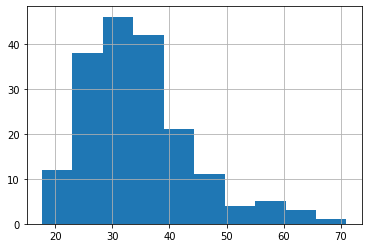

In [254]:
pd.Series(y_pred).hist()

In [255]:
save_object(model_reg, './saved_model/lasso_model_age.pkl')

## Xgboost

In [256]:
import xgboost as xgb

In [257]:
dtrain = xgb.DMatrix(X,label=y)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
param = {'max_depth':9, 'eta':0.01, 'objective':'reg:squarederror', 'silent':0, 'colsample_bytree':0.3}
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
num_round = 1000
bst = xgb.train(param, dtrain, num_round, 
                evals = watchlist, 
                early_stopping_rounds=21, 
               verbose_eval=50,)
y_pred = bst.predict(dvalid)

[0]	eval-rmse:36.0792	train-rmse:35.3741
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 21 rounds.
[50]	eval-rmse:23.6531	train-rmse:22.1827
[100]	eval-rmse:16.3298	train-rmse:14.035
[150]	eval-rmse:12.1984	train-rmse:8.97414
[200]	eval-rmse:9.96115	train-rmse:5.82595
[250]	eval-rmse:8.82305	train-rmse:3.87669
[300]	eval-rmse:8.23025	train-rmse:2.68664
[350]	eval-rmse:7.92862	train-rmse:1.98597
[400]	eval-rmse:7.768	train-rmse:1.59888
[450]	eval-rmse:7.6778	train-rmse:1.39829
[500]	eval-rmse:7.62649	train-rmse:1.29926
[550]	eval-rmse:7.59756	train-rmse:1.2521
[600]	eval-rmse:7.57944	train-rmse:1.22972
[650]	eval-rmse:7.56681	train-rmse:1.21883
[700]	eval-rmse:7.55816	train-rmse:1.21344
[750]	eval-rmse:7.55251	train-rmse:1.21066
[800]	eval-rmse:7.5488	train-rmse:1.20915
[850]	eval-rmse:7.54651	train-rmse:1.20832
[900]	eval-rmse:7.5449	train-rmse:1.20785
[950]	eval-rmse:7.54393	train-rmse:1.20755
[999]

In [190]:
print('rmse: %5.3f'%(mean_squared_error(y_valid, y_pred) ** 0.5))
print('mae: %5.3f'%(mean_absolute_error(y_valid, y_pred)))
print('r2: %5.3f'%(r2_score(y_valid, y_pred)))
print('cor: %5.3f with p-valud %0.3f'%(pearsonr(y_valid, y_pred)))

rmse: 4.665
mae: 3.521
r2: 0.241
cor: 0.512 with p-valud 0.000


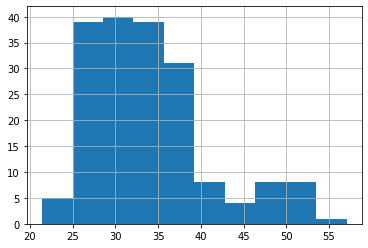

In [258]:
pd.Series(y_pred).hist()

# Prediction

In [259]:
def predict_bmi(model, face_array):
    """ predcit bmi from face array or face array path (pickle file)
    Args: face_array (dict or path string)
    Return: BMI in float
    """

    if type(face_array) == str:
        with open(face_array,'rb') as f:
            face_array = pickle.load(f)
    
    df_test = pd.DataFrame(face_array).T
    res = pd.DataFrame({'name': df_test.index.tolist(), 
              'bmi_predicted':model.predict(df_test.values)})
    return res

In [260]:
predict_bmi(model_reg, './face_array_test.pkl')

,name,bmi_predicted
0,barack-obama.jpg,46.147903
1,clinton-3.jpg,64.415108
2,emma_watson.jpg,29.875290
3,kent_cheng.jpg,38.217903
4,kent_zheng.jpg,30.169107
5,leonardo1.jpeg,38.127434
6,Leonardo_Dicaprio_Cannes_2019.jpg,58.052757
7,trump.jpg,71.882805
8,xi.jpg,52.036121


In [261]:
predict_bmi(model_reg, extract_feature(input='./test/0/me.jpg'))

converting images from ./test/0/me.jpg


,name,bmi_predicted
0,me.jpg,25.878784
